# Preprocessing et data analyse

### Import des données et 1ères analyses

In [1]:
import pandas as pd
import numpy as np
import time
import missingno as msno
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
from pyarrow import csv
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso

from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from catboost import Pool, CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
import pickle

import warnings
warnings.filterwarnings('ignore')

Installation des librairies manquantes :
pip install missingno
pip install catboost
pip install lightgbm

Certaines modifications ont été apportées au fichier Excel, comme certaines données qui n'ont pas été prises à tord et également pour certaines SCPI créé en 2018 et intéressantes à analyser, où des données ont été dupliquées de 2019 si elles restent du même ordre.

In [2]:
path_data_row = "C:/Users/paulj/Documents/Projets data/SCPI-analyses/SCPI-analyses/data/raw/"
path_data_processed = "C:/Users/paulj/Documents/Projets data/SCPI-analyses/SCPI-analyses/data/processed/"
year = 2022
df = pd.read_excel(path_data_row + 'df_brut_modif.xlsx',index_col=0)
df.head()

,scpi_liste,type_SCPI,categorie,capital,creation,capitalisation,nb_associes,taux_occupation_financier,nb_immeubles,RAN,...,variation_prix_2018,variation_prix_2019,variation_prix_2020,variation_prix_2021,variation_prix_2022,pct_distrib_2018,pct_distrib_2019,pct_distrib_2020,pct_distrib_2021,pct_distrib_2022
0,allianz-home,SCPI de rendement,Diversifiée,Variable,2021,39.91M€,867,100.00 %,1,0 %,...,NaN,NaN,NaN,0.00%,0.00%,NaN,NaN,NaN,0.00%,0.00%
1,corum-xl,SCPI de Rendement,Diversifiée,Variable,2016,322.96M€,40 109,99.52 %,70,NaN,...,0%,1%,0%,0%,0%,0%,6.26%,4.47%,5.84%,5.97%
2,remake-live,SCPI de rendement,Diversifiée,Variable,2022,237.59M€,408,100.00 %,18,0 %,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,novapierre-1,SCPI de rendement,Commerces,Variable,1999,237.59M€,2 428,86.9 %,136,"10,33 %",...,1.38%,0.93%,0.00%,0.00%,0.00%,3.95%,4.21%,3.70%,4.80%,4.51%
4,laffitte-pierre,SCPI de rendement,Bureaux,Variable,2000,886.7M€,21 179,90.06 %,74,"20,46 %",...,0.00%,0.98%,3.17%,0.45%,0%,3.85%,4.03%,3.49%,3.53%,4.00%


Voici quelques définitions pour rappel :
- pourcentage de distribution : rendement par rapport à l'investissement initial
- variation prix : variation du prix de la part d'une année sur l'autre
- Capital :
Une SCPI à capital variable permet d'acheter des parts dont le prix varie en fonction du marché immobilier, alors qu'une SCPI à capital fixe permet d'acheter des parts dont le prix varie en fonction de leurs attraits auprès des investisseurs.
- Taux d'occupation financier :
total des loyers et indemnités facturés divisés par le total des loyers qui seraient facturés si les locaux étaient intégralement loués.

- RAN : Report À Nouveau, c'est une réserve financière

En général, il y a des frais de souscription et des frais de gestion mais les pourcentages de distribution sont calculés par rapport au prix total, donc net de ces frais.

On va à présent avoir un 1er aperçu des variables et des valeurs manquantes que l'on peut trouver.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 0 to 107
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   scpi_liste                 108 non-null    object
 1   type_SCPI                  108 non-null    object
 2   categorie                  108 non-null    object
 3   capital                    108 non-null    object
 4   creation                   108 non-null    object
 5   capitalisation             108 non-null    object
 6   nb_associes                104 non-null    object
 7   taux_occupation_financier  100 non-null    object
 8   nb_immeubles               103 non-null    object
 9   RAN                        100 non-null    object
 10  pct_charge                 85 non-null     object
 11  variation_prix_2018        82 non-null     object
 12  variation_prix_2019        83 non-null     object
 13  variation_prix_2020        92 non-null     object
 14  variation_prix_

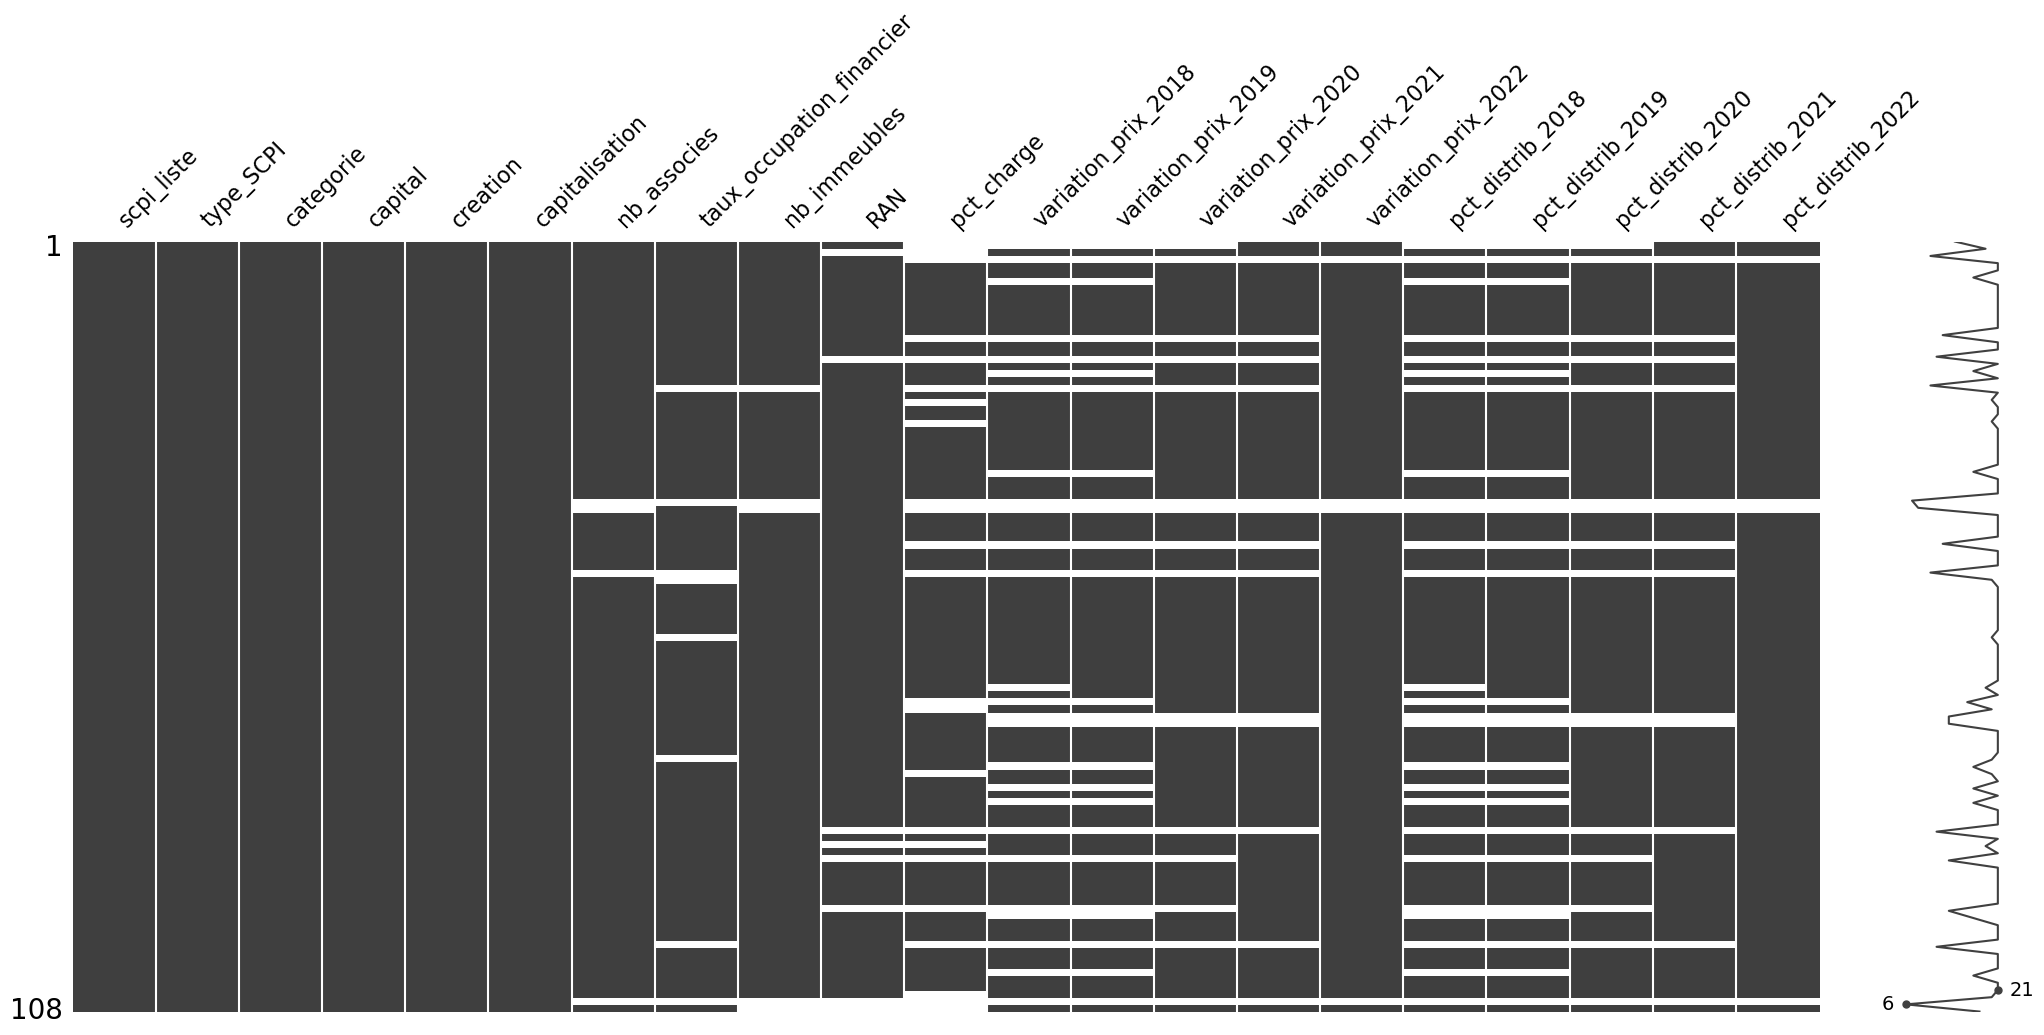

In [4]:
msno.matrix(df)
plt.show()
plt.close()

Remise en forme, suppression de lignes avec valeurs manquantes et redéfinition des types de variables :

### Fonctions de transformation

In [5]:
def preprocessing_categorical_data_analysis(dataframe:pd.DataFrame, year:int) -> pd.DataFrame:
    
    dataframe.creation=dataframe.creation.apply(lambda x: x[-4:] if isinstance(x, str) else x)
    dataframe.iloc[:, 4:]=dataframe.iloc[:, 4:].applymap(lambda x: x.replace('%','').replace(' ','').replace(',','.').replace('M€','') if isinstance(x, str) else x)

    dataframe = dataframe.replace('-',np.NaN)
    
    moyenne_str = str(dataframe['taux_occupation_financier'].astype({'taux_occupation_financier':'float'}).dropna().mean())
    dataframe['taux_occupation_financier']=dataframe['taux_occupation_financier'].fillna(moyenne_str)
    moyenne2_str = str(dataframe['RAN'].astype({'RAN':'float'}).dropna().mean())
    dataframe['RAN']=dataframe['RAN'].fillna(moyenne2_str)
    dataframe['nb_associes']=dataframe['nb_associes'].fillna(0)
    moyenne3_str = str(int(dataframe['nb_immeubles'].astype({'nb_immeubles':'float'}).dropna().mean()))
    dataframe['nb_immeubles']=dataframe['nb_immeubles'].fillna(moyenne3_str)
    moyenne4_str = str(dataframe['pct_charge'].astype({'pct_charge':'float'}).dropna().mean())
    dataframe['pct_charge']=dataframe['pct_charge'].fillna(moyenne4_str)
    
    dataframe=dataframe.astype({
    'scpi_liste':'string',
    'type_SCPI':'string',
    'categorie':'string',
    'capital':'string',
    'creation':'int',
    'capitalisation':'float',
    'nb_associes':'int',
    'taux_occupation_financier':'float',
    'nb_immeubles':'int',
    'RAN':'float',
    'pct_charge':'float',    
    
    'pct_distrib_'+str(year-4):'float',
    'pct_distrib_'+str(year-3):'float',
    'pct_distrib_'+str(year-2):'float',
    'pct_distrib_'+str(year-1):'float',
    'pct_distrib_'+str(year):'float',
    'variation_prix_'+str(year-4):'float',
    'variation_prix_'+str(year-3):'float',
    'variation_prix_'+str(year-2):'float',
    'variation_prix_'+str(year-1):'float',
    'variation_prix_'+str(year):'float'

    })


    dataframe.type_SCPI = dataframe.type_SCPI.apply(lambda x:x.replace('Rendement','rendement'))
    dataframe['type_SCPI'][dataframe['type_SCPI']=='rendement'] = 'SCPI de rendement'
    dataframe.type_SCPI = dataframe.type_SCPI.apply(lambda x:x.replace('SCPI de plus-value','SCPI de plus value'))
    dataframe.categorie = dataframe.categorie.apply(lambda x:x.replace('Activité / Logistique','Activités / Logistique'))
    dataframe.categorie = dataframe.categorie.apply(lambda x:x.replace('Résidentielle','Résidentiel'))
    dataframe.categorie = dataframe.categorie.apply(lambda x:x.replace('Commerces','Commerce'))
    dataframe.categorie = dataframe.categorie.apply(lambda x:x.replace('Bureaux','Bureau'))
    dataframe.categorie = dataframe.categorie.apply(lambda x:x.replace('Santé et éducation ', 'Santé et éducation'))
    return dataframe

def preprocessing_all_Nan_resolved_data_analysis(dataframe:pd.DataFrame, year:int) -> pd.DataFrame:
    
    dataframe=dataframe.dropna()
    
    dataframe['pct_distrib_var_'+str(year-4)+'_'+str(year-3)]=dataframe.apply(lambda x:x['pct_distrib_'+str(year-3)]-x['pct_distrib_'+str(year-4)],axis=1)
    dataframe['pct_distrib_var_'+str(year-3)+'_'+str(year-2)]=dataframe.apply(lambda x:x['pct_distrib_'+str(year-2)]-x['pct_distrib_'+str(year-3)],axis=1)
    dataframe['pct_distrib_var_'+str(year-2)+'_'+str(year-1)]=dataframe.apply(lambda x:x['pct_distrib_'+str(year-1)]-x['pct_distrib_'+str(year-2)],axis=1)
    dataframe['pct_distrib_var_'+str(year-1)+'_'+str(year)]=dataframe.apply(lambda x:x['pct_distrib_'+str(year)]-x['pct_distrib_'+str(year-1)],axis=1)

    dataframe['rentabilite_totale_'+str(year-4)]=dataframe.apply(lambda x:x['pct_distrib_'+str(year-4)]+x['variation_prix_'+str(year-4)],axis=1)
    dataframe['rentabilite_totale_'+str(year-3)]=dataframe.apply(lambda x:x['pct_distrib_'+str(year-3)]+x['variation_prix_'+str(year-3)],axis=1)
    dataframe['rentabilite_totale_'+str(year-2)]=dataframe.apply(lambda x:x['pct_distrib_'+str(year-2)]+x['variation_prix_'+str(year-2)],axis=1)
    dataframe['rentabilite_totale_'+str(year-1)]=dataframe.apply(lambda x:x['pct_distrib_'+str(year-1)]+x['variation_prix_'+str(year-1)],axis=1)
    dataframe['rentabilite_totale_'+str(year)]=dataframe.apply(lambda x:x['pct_distrib_'+str(year)]+x['variation_prix_'+str(year)],axis=1)

    dataframe['volatilite_pct_distrib']=dataframe.apply(lambda x:((x['pct_distrib_var_'+str(year-4)+'_'+str(year-3)]**2+x['pct_distrib_var_'+str(year-3)+'_'+str(year-2)]**2+x['pct_distrib_var_'+str(year-2)+'_'+str(year-1)]**2+x['pct_distrib_var_'+str(year-1)+'_'+str(year)]**2)/4)**0.5,axis=1)
    dataframe['volatilite_variation_prix']=dataframe.apply(lambda x:((x['variation_prix_'+str(year-3)]**2+x['variation_prix_'+str(year-2)]**2+x['variation_prix_'+str(year-1)]**2+x['variation_prix_'+str(year)]**2)/4)**0.5,axis=1)
    dataframe['variation_prix_min']=dataframe.apply(lambda x:min(x['variation_prix_'+str(year-3)],x['variation_prix_'+str(year-2)],x['variation_prix_'+str(year-1)],x['variation_prix_'+str(year)]),axis=1)
    
    dataframe['moyenne_pct_distrib_'+str(year-4)+'_'+str(year-1)]=dataframe.apply(lambda x:(x['pct_distrib_'+str(year-4)]+x['pct_distrib_'+str(year-3)]+x['pct_distrib_'+str(year-2)]+x['pct_distrib_'+str(year-1)])/4,axis=1)
    dataframe['moyenne_rentabilite_totale_'+str(year-4)+'_'+str(year-1)]=dataframe.apply(lambda x:(x['rentabilite_totale_'+str(year-4)]+x['rentabilite_totale_'+str(year-3)]+x['rentabilite_totale_'+str(year-2)]+x['rentabilite_totale_'+str(year-1)])/4,axis=1)

    return dataframe

def transform_to_correlation_analysis(dataframe:pd.DataFrame) -> pd.DataFrame:
    dataframe.to_excel(path_data_processed + 'dataframe_sans_dummies.xlsx')
    dataframe = dataframe.drop('scpi_liste',axis=1)
    le = LabelEncoder()
    dataframe['capital'] = le.fit_transform(dataframe['capital'])
    dataframe['type_SCPI'] = le.fit_transform(dataframe['type_SCPI'])
    dataframe=pd.get_dummies(dataframe)
    
    return dataframe

def transform_to_ML(dataframe:pd.DataFrame) -> pd.DataFrame:
    
    dataframe=dataframe.drop(index=6,axis=0)
    dataframe=dataframe.drop(index=96,axis=0)
    print("Après drop :")
    print("mean_squared_error entre la rentabilité de", year, "et la moyenne des années précédentes :", mean_squared_error(dataframe['moyenne_rentabilite_totale_'+str(year-4)+'_'+str(year-1)],dataframe['pct_distrib_'+str(year)]))
    print("mean_squared_error entre la pct de distribution de", year, "et la moyenne des années précédentes :", mean_squared_error(dataframe['moyenne_pct_distrib_'+str(year-4)+'_'+str(year-1)],dataframe['pct_distrib_'+str(year)]))
    dataframe=dataframe.drop(['creation','capitalisation','taux_occupation_financier','nb_associes','RAN',
                              'rentabilite_totale_'+str(year-4),'rentabilite_totale_'+str(year-3),'rentabilite_totale_'+str(year-2),'rentabilite_totale_'+str(year-1),'rentabilite_totale_'+str(year),
                              'pct_distrib_var_'+str(year-4)+'_'+str(year-3),'pct_distrib_var_'+str(year-3)+'_'+str(year-2),'pct_distrib_var_'+str(year-2)+'_'+str(year-1),'pct_distrib_var_'+str(year-1)+'_'+str(year),
                              'volatilite_pct_distrib','volatilite_variation_prix',
                              'moyenne_rentabilite_totale_'+str(year-4)+'_'+str(year-1),'moyenne_pct_distrib_'+str(year-4)+'_'+str(year-1)],axis=1)
    
    return dataframe

def dataframe_means_from_criteria(year:int, dataframe:pd.DataFrame, col_mean:str, col_criteria:str) -> pd.DataFrame:
    df_moyennes = dataframe[[col_criteria,col_mean+'_'+str(year-4)]].dropna().groupby([col_criteria]).mean()
    df_moyennes[col_mean+'_'+str(year-3)] = dataframe[[col_criteria,col_mean+'_'+str(year-3)]].dropna().groupby([col_criteria]).mean()
    df_moyennes[col_mean+'_'+str(year-2)] = dataframe[[col_criteria,col_mean+'_'+str(year-2)]].dropna().groupby([col_criteria]).mean()
    df_moyennes[col_mean+'_'+str(year-1)] = dataframe[[col_criteria,col_mean+'_'+str(year-1)]].dropna().groupby([col_criteria]).mean()
    df_moyennes[col_mean+'_'+str(year)] = dataframe[[col_criteria,col_mean+'_'+str(year)]].dropna().groupby([col_criteria]).mean()
    df_moyennes["moyenne sur l'ensemble"]=(df_moyennes[col_mean+'_'+str(year-3)]+df_moyennes[col_mean+'_'+str(year-2)]+df_moyennes[col_mean+'_'+str(year-1)]+df_moyennes[col_mean+'_'+str(year)])/4
    df_moyennes=df_moyennes.sort_values(by=["moyenne sur l'ensemble"],ascending = False)
    
    new_row = pd.DataFrame({
    col_mean+'_'+str(year-4): [dataframe[col_mean+'_'+str(year-4)].mean()],
    col_mean+'_'+str(year-3): [dataframe[col_mean+'_'+str(year-3)].mean()],
    col_mean+'_'+str(year-2): [dataframe[col_mean+'_'+str(year-2)].mean()],
    col_mean+'_'+str(year-1): [dataframe[col_mean+'_'+str(year-1)].mean()],
    col_mean+'_'+str(year): [dataframe[col_mean+'_'+str(year)].mean()],
    "moyenne sur l'ensemble": [(dataframe[col_mean+'_'+str(year-4)].mean()+dataframe[col_mean+'_'+str(year-3)].mean()+dataframe[col_mean+'_'+str(year-2)].mean()+dataframe[col_mean+'_'+str(year-1)].mean()+dataframe[col_mean+'_'+str(year)].mean())/5]
    }, index=["Total"])

    df_moyennes = pd.concat([df_moyennes, new_row])
    
    return df_moyennes

def plot_from_dataframe(dataframe:pd.DataFrame, title_input:str) -> None:
    plt.figure(figsize=(12, 8))
    plt.plot(dataframe.T)
    plt.legend(labels=dataframe.index)
    plt.title(title_input)
    plt.show()
    plt.close()


def bar_from_dataframe(labels, values, titre:str) -> None:
    plt.bar(labels,values)
    plt.xticks(rotation=45, ha='right')  # "ha" signifie "horizontal alignment"
    plt.title(titre)
    plt.show()
    plt.close()


def bar_value_count_from_dataframe(dataframe:pd.DataFrame,libelle_var:str, titre:str) -> None:
    vc = dataframe[libelle_var].value_counts()
    print(vc)
    plt.bar(vc.index,vc.values)
    plt.title(titre)
    plt.show()
    plt.close()


def donut_chart_from_dataframe(dataframe:pd.DataFrame,libelle_var:str, titre:str) -> None:
    #dataframe[libelle_var].value_counts().plot(kind='pie',title=titre) #version basique
    plt.figure(figsize=(7,7))
    plt.pie(
    x=list(dataframe[libelle_var].value_counts()), 
    labels=dataframe[libelle_var].drop_duplicates(),
    startangle=0,
    pctdistance=0.90,
    autopct='%1.1f%%'
    )
    hole = plt.Circle((0, 0), 0.65, facecolor='white')
    plt.gcf().gca().add_artist(hole)
    
    plt.title(titre)
    plt.show()
    plt.close()



def correlation_importance_target(dataframe:pd.DataFrame, target:str) -> pd.DataFrame:
    df_corr = dataframe.corr()
    df_corr_importance = df_corr[target].abs().sort_values(ascending=False)
    plt.subplots(figsize = (30, 22))
    sns.heatmap(dataframe.corr(), annot=True)
    plt.title("Heatmap de corrélation des variables", fontsize = 14)
    plt.show()
    plt.close()
    
    return df_corr_importance
    
def add_to_dataframe_means_variation_prix(dataframe:pd.DataFrame, year:int) -> pd.DataFrame:
    df_variation_prix_selon_categorie = dataframe_means_from_criteria(year,dataframe,'variation_prix','categorie')
    moy_Residentiel, moy_Sante, moy_Tourisme, moy_Diversifiee, moy_Bureaux, moy_Commerce, moy_Activites, moy_Total = df_variation_prix_selon_categorie["moyenne sur l'ensemble"].to_list()

    conditions = [
    (dataframe['categorie'] == 'Résidentiel'),
    (dataframe['categorie'] == 'Santé et éducation'),
    (dataframe['categorie'] == 'Tourisme et loisirs'),
    (dataframe['categorie'] == 'Diversifiée'),
    (dataframe['categorie'] == 'Bureaux'),
    (dataframe['categorie'] == 'Commerce'),
    (dataframe['categorie'] == 'Activités / Logistique'),
    (dataframe['categorie'] == 'Total')        
    ]
    choices = [moy_Residentiel, moy_Sante, moy_Tourisme, moy_Diversifiee, moy_Bureaux, moy_Commerce, moy_Activites, moy_Total]

    dataframe['moyenne_variation_prix_'+str(year-4)+'_'+str(year)] = np.select(conditions, choices, default=np.nan)
    
    return dataframe   

In [6]:
df = preprocessing_categorical_data_analysis(df,year)
df.head()

,scpi_liste,type_SCPI,categorie,capital,creation,capitalisation,nb_associes,taux_occupation_financier,nb_immeubles,RAN,...,variation_prix_2018,variation_prix_2019,variation_prix_2020,variation_prix_2021,variation_prix_2022,pct_distrib_2018,pct_distrib_2019,pct_distrib_2020,pct_distrib_2021,pct_distrib_2022
0,allianz-home,SCPI de rendement,Diversifiée,Variable,2021,39.91,867,100.00,1,0.000000,...,NaN,NaN,NaN,0.00,0.0,NaN,NaN,NaN,0.00,0.00
1,corum-xl,SCPI de rendement,Diversifiée,Variable,2016,322.96,40109,99.52,70,28.157442,...,0.00,1.00,0.00,0.00,0.0,0.00,6.26,4.47,5.84,5.97
2,remake-live,SCPI de rendement,Diversifiée,Variable,2022,237.59,408,100.00,18,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,novapierre-1,SCPI de rendement,Commerce,Variable,1999,237.59,2428,86.90,136,10.330000,...,1.38,0.93,0.00,0.00,0.0,3.95,4.21,3.70,4.80,4.51
4,laffitte-pierre,SCPI de rendement,Bureau,Variable,2000,886.70,21179,90.06,74,20.460000,...,0.00,0.98,3.17,0.45,0.0,3.85,4.03,3.49,3.53,4.00


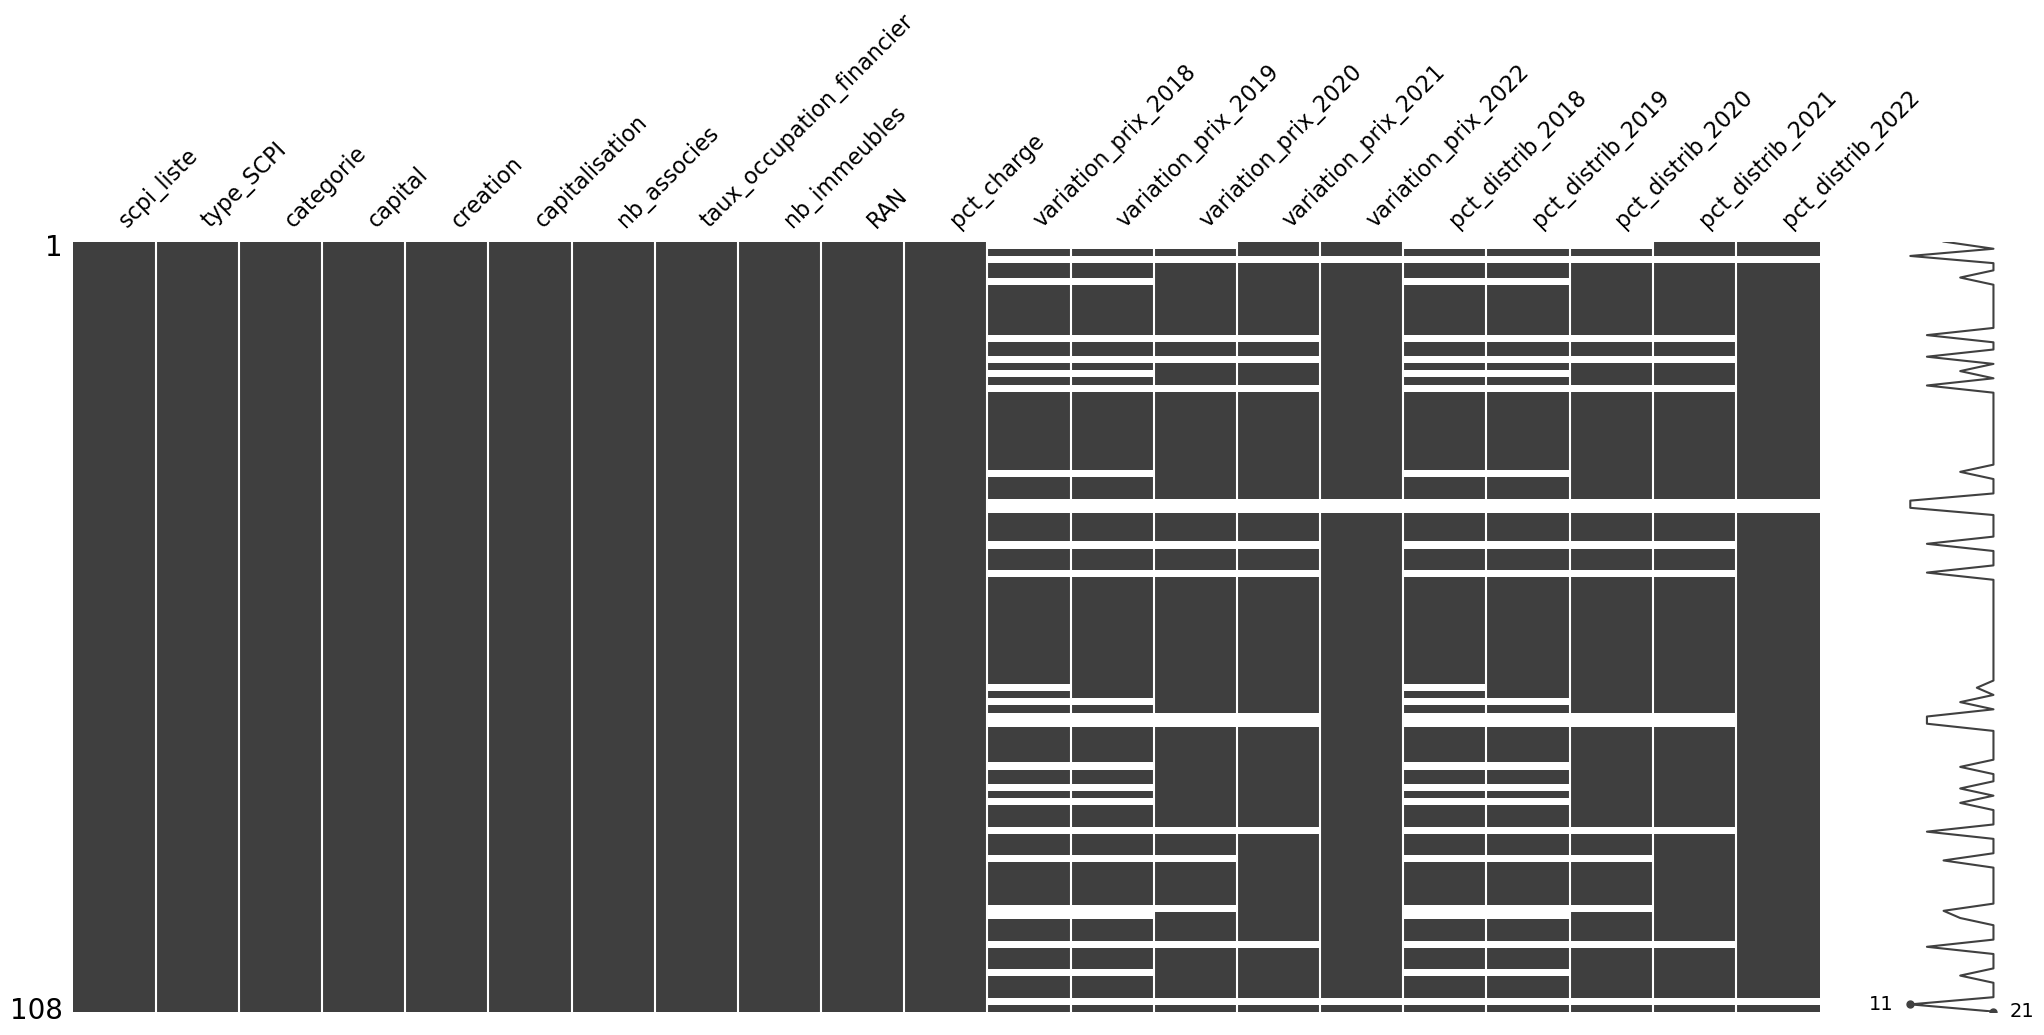

In [7]:
msno.matrix(df)
plt.show()
plt.close()

# Data analysis

### 1ères analyses et études des outliers

Voici une 1ère description statistique :

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
creation,108.0,2003.944444,16.529121,1966.000,1988.0000,2012.000,2018.00000,2022.00
capitalisation,108.0,716.094722,1104.276625,4.130,66.3000,247.800,989.70000,5156.73
nb_associes,108.0,11469.861111,14914.261611,0.000,1294.2500,5152.000,14311.50000,60574.00
taux_occupation_financier,108.0,93.287720,11.177407,0.882,91.8300,94.890,97.72500,100.00
nb_immeubles,108.0,104.370370,129.583127,1.000,25.0000,70.500,138.50000,1035.00
RAN,108.0,28.157442,50.998052,-134.300,1.8600,13.605,33.39750,337.00
pct_charge,108.0,34.759950,23.047130,0.000,24.0000,32.190,34.75995,164.18
variation_prix_2018,82.0,0.892927,2.795316,-4.820,0.0000,0.000,1.27000,16.74
variation_prix_2019,83.0,1.084819,3.841995,-15.100,0.0000,0.520,1.74000,23.04
variation_prix_2020,92.0,1.075326,3.523836,-11.300,0.0000,0.000,1.14000,18.57


Ici, on va visualiser la proportion de SCPI par type ou par catégorie :

type_SCPI
SCPI de rendement     106
SCPI de plus value      2
Name: count, dtype: int64


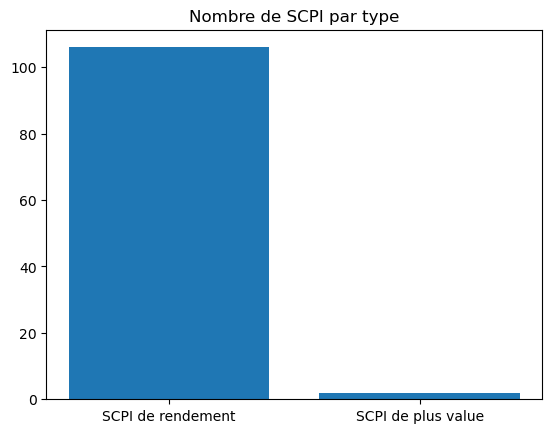

In [9]:
bar_value_count_from_dataframe(df,'type_SCPI',"Nombre de SCPI par type")

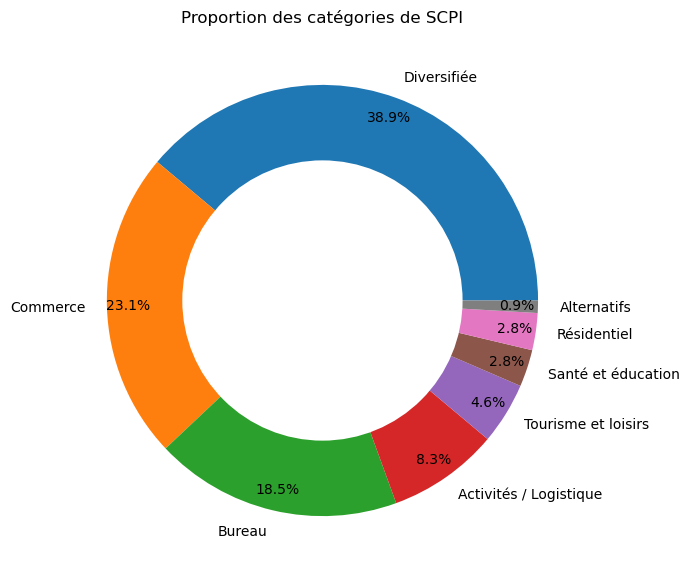

In [10]:
donut_chart_from_dataframe(df,'categorie','Proportion des catégories de SCPI')

On va à présent calculer les différences des distributions entre chaque année et calculer la rentabilité comme étant la somme du pourcentage de distribution et de l'augmentation en capital (variation_prix). En revanche, il peut y avoir des frais au moment de la revente.

On calcule également la volatilité pour voir si le pourcentage de distribution et la variation des prix ne varient pas excessivement d'une année sur l'autre, induisant un risque élevé.

On va à présent utiliser les SCPI ayant 5 années consécutives de données.

In [11]:
df = preprocessing_all_Nan_resolved_data_analysis(df,year)

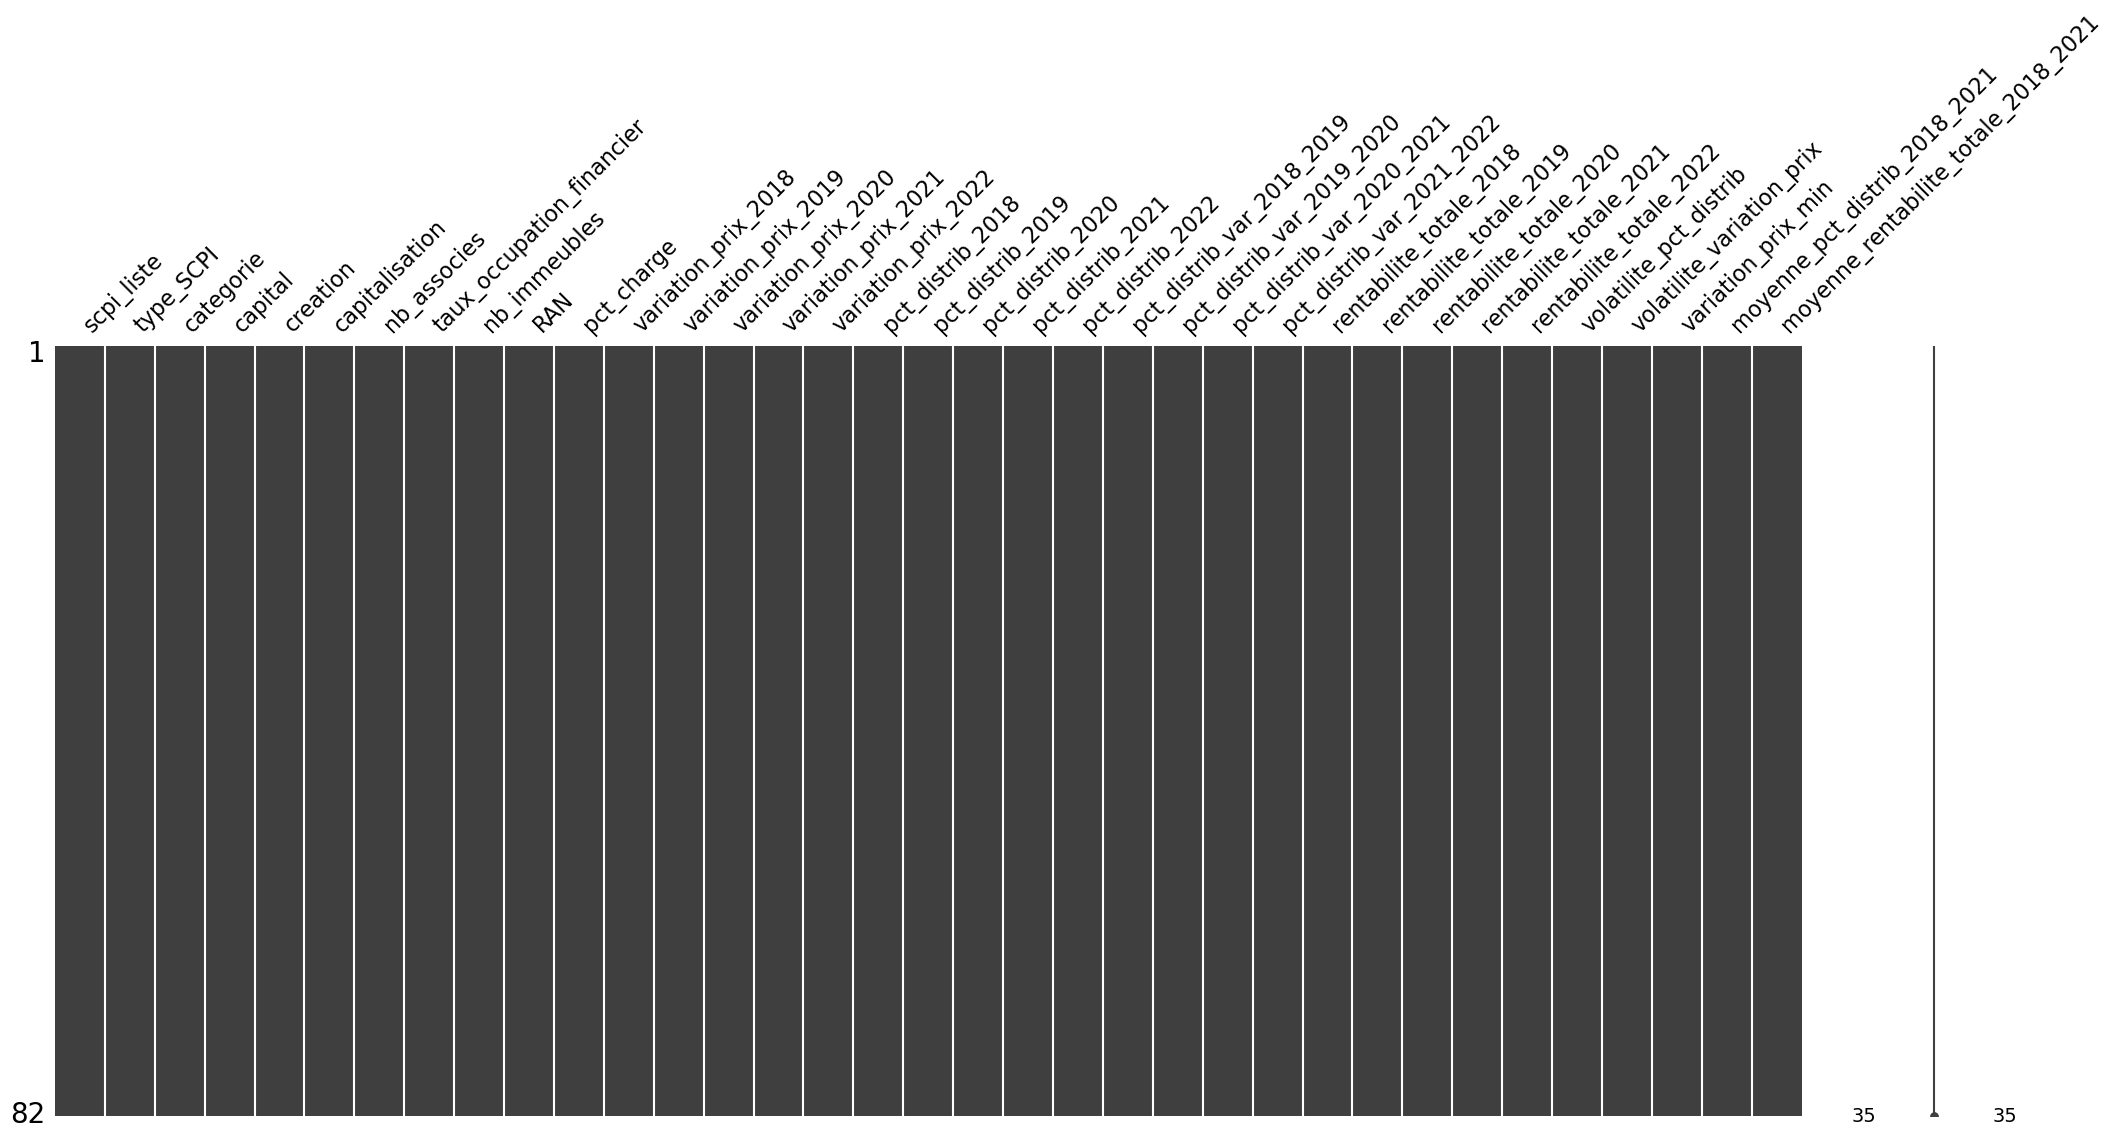

In [12]:
msno.matrix(df)
plt.show()
plt.close()

In [13]:
df.head()

,scpi_liste,type_SCPI,categorie,capital,creation,capitalisation,nb_associes,taux_occupation_financier,nb_immeubles,RAN,...,rentabilite_totale_2018,rentabilite_totale_2019,rentabilite_totale_2020,rentabilite_totale_2021,rentabilite_totale_2022,volatilite_pct_distrib,volatilite_variation_prix,variation_prix_min,moyenne_pct_distrib_2018_2021,moyenne_rentabilite_totale_2018_2021
1,corum-xl,SCPI de rendement,Diversifiée,Variable,2016,322.96,40109,99.52,70,28.157442,...,0.00,7.26,4.47,5.84,5.97,3.327368,0.500000,0.0,4.1425,4.3925
3,novapierre-1,SCPI de rendement,Commerce,Variable,1999,237.59,2428,86.90,136,10.330000,...,5.33,5.14,3.70,4.80,4.51,0.636750,0.465000,0.0,4.1650,4.7425
4,laffitte-pierre,SCPI de rendement,Bureau,Variable,2000,886.70,21179,90.06,74,20.460000,...,3.85,5.01,6.66,3.98,4.00,0.369628,1.674201,0.0,3.7250,4.8750
6,capiforce,SCPI de rendement,Commerce,Fixe,1982,42.30,3346,94.98,95,34.630000,...,0.35,-7.15,-1.46,6.06,-0.65,1.529820,8.829326,-13.1,5.6700,-0.5500
7,buroboutic,SCPI de rendement,Diversifiée,Variable,1986,75.30,6927,90.21,176,7.890000,...,4.34,4.42,4.27,4.08,4.31,0.171683,0.000000,0.0,4.2775,4.2775


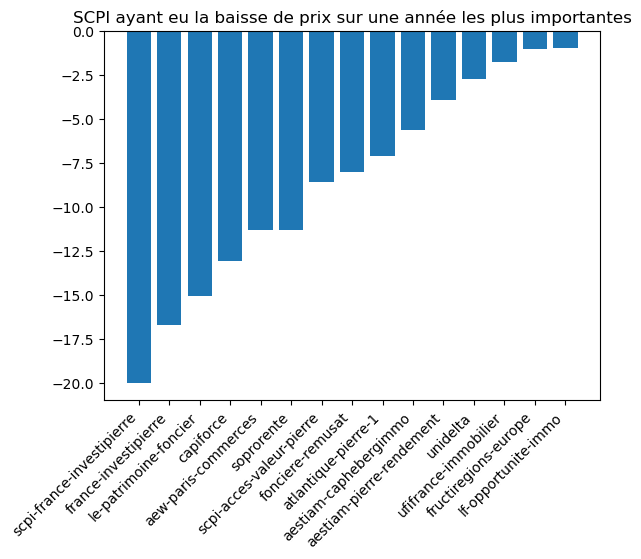

In [14]:
df_variation_prix_min = df.sort_values(by='variation_prix_min', ascending=True).head(15)
bar_from_dataframe(df_variation_prix_min['scpi_liste'],df_variation_prix_min['variation_prix_min'], 'SCPI ayant eu la baisse de prix sur une année les plus importantes')

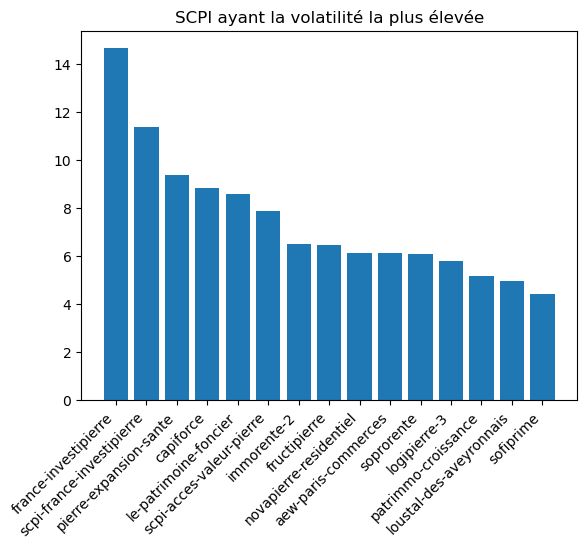

In [15]:
df_volatilite_variation_prix = df.sort_values(by='volatilite_variation_prix', ascending=False).head(15)
bar_from_dataframe(df_volatilite_variation_prix['scpi_liste'], df_volatilite_variation_prix['volatilite_variation_prix'], 'SCPI ayant la volatilité la plus élevée')

In [16]:
df[['volatilite_variation_prix','variation_prix_min']].describe().round(2)

,volatilite_variation_prix,variation_prix_min
count,82.00,82.00
mean,2.30,-1.49
std,2.89,4.18
min,0.00,-20.00
25%,0.50,0.00
50%,1.11,0.00
75%,2.87,0.00
max,14.63,2.26


On va calculer la moyenne entre les années avant 2022 et les comparer par rapport à l'année 2022 ce qui nous permet déjà d'avoir une estimation de la rentabilité d'une SCPI.

In [17]:
print("Moyenne du carrée des erreurs entre la rentabilité totale de", year, "et la moyenne des années précédentes :", round(mean_squared_error(df['moyenne_rentabilite_totale_'+str(year-4)+'_'+str(year-1)],df['rentabilite_totale_'+str(year)]),3))
print("Moyenne du carrée des erreurs entre la pct de distribution de", year, "et la moyenne des années précédentes :", round(mean_squared_error(df['moyenne_pct_distrib_'+str(year-4)+'_'+str(year-1)],df['pct_distrib_'+str(year)]),3))

Moyenne du carrée des erreurs entre la rentabilité totale de 2022 et la moyenne des années précédentes : 22.446
Moyenne du carrée des erreurs entre la pct de distribution de 2022 et la moyenne des années précédentes : 0.76


In [18]:
df[['scpi_liste','moyenne_rentabilite_totale_'+str(year-4)+'_'+str(year-1),'rentabilite_totale_'+str(year),'moyenne_pct_distrib_'+str(year-4)+'_'+str(year-1),'pct_distrib_'+str(year)]].sort_values(by=['pct_distrib_'+str(year)],ascending = False)

,scpi_liste,moyenne_rentabilite_totale_2018_2021,rentabilite_totale_2022,moyenne_pct_distrib_2018_2021,pct_distrib_2022
6,capiforce,-0.5500,-0.65,5.6700,8.93
85,corum-origin,7.3600,6.88,6.6600,6.88
88,coeur-de-regions,7.0075,8.13,6.3075,6.40
74,neo,6.3575,9.22,6.3575,6.33
99,le-patrimoine-foncier,1.1075,14.18,4.7375,5.99
...,...,...,...,...,...
100,loustal-des-aveyronnais,7.0200,6.77,3.1775,2.87
75,novapierre-residentiel,5.2300,12.21,2.0250,1.64
44,sofiprime,2.2025,5.66,0.3950,0.50
96,cm-cic-pierre-investissement,4.3900,0.00,4.4675,0.00


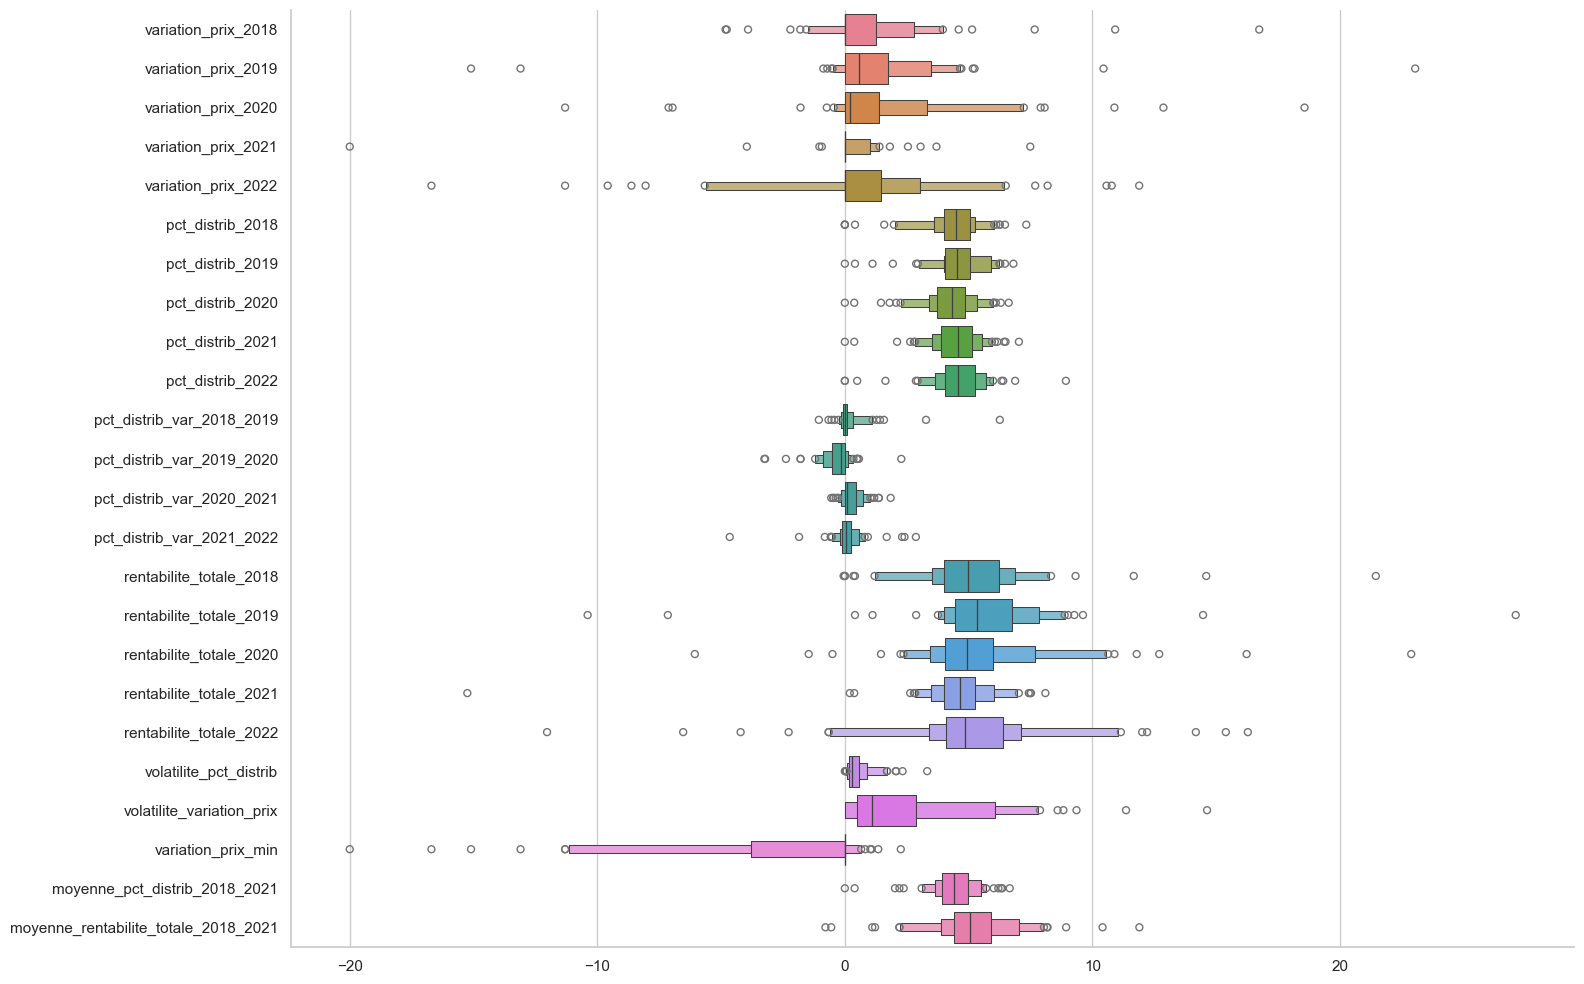

In [19]:
sns.set_theme()
sns.set_style('whitegrid')
sns.catplot(data=df.drop(['capitalisation','nb_associes','creation','nb_immeubles','RAN','pct_charge','taux_occupation_financier'],axis=1), kind='boxen', orient='h', height=10, aspect=1.6);# , color=df.index, palette='rainbow'
plt.show()
plt.close()

On constate que les variation du prix d'acquisition sont plus hétérogènes que les pourcentages de distribution.

### Graphiques concernant le taux de distribution (en %)

On va alors calculer la moyenne des pourcentages de distribution en fonction de chaque année et par catégorie :

In [20]:
df_pct_distrib_selon_categorie = dataframe_means_from_criteria(year,df,'pct_distrib','categorie')
df_pct_distrib_selon_categorie

,pct_distrib_2018,pct_distrib_2019,pct_distrib_2020,pct_distrib_2021,pct_distrib_2022,moyenne sur l'ensemble
Diversifiée,4.931538,5.342308,4.741538,5.124615,5.336923,5.136346
Activités / Logistique,4.650000,5.040000,4.520000,5.210000,5.410000,5.045000
Santé et éducation,4.522500,4.915000,4.715000,4.762500,4.842500,4.808750
Commerce,4.375000,4.488889,4.323333,4.663333,4.913333,4.597222
Bureau,4.383158,4.430789,4.310526,4.431579,4.330000,4.375724
Tourisme et loisirs,4.676667,4.830000,1.880000,2.983333,5.120000,3.703333
Résidentiel,1.984000,2.638000,2.410000,2.292000,2.090000,2.357500
Total,4.342805,4.524390,4.199146,4.434512,4.548171,4.409805


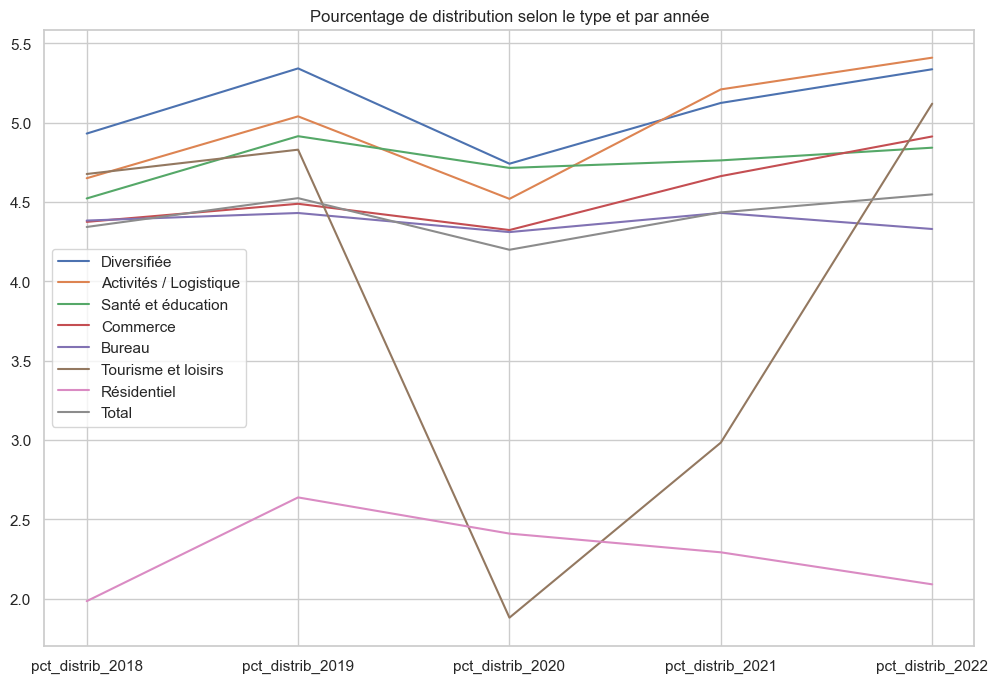

In [21]:
plot_from_dataframe(df_pct_distrib_selon_categorie.drop("moyenne sur l'ensemble",axis=1),"Pourcentage de distribution selon le type et par année")

In [22]:
df_pct_distrib_selon_capital = dataframe_means_from_criteria(year,df,'pct_distrib','capital')
df_pct_distrib_selon_capital

,pct_distrib_2018,pct_distrib_2019,pct_distrib_2020,pct_distrib_2021,pct_distrib_2022,moyenne sur l'ensemble
Fixe,4.379412,4.429412,4.272941,4.476471,4.540000,4.429706
Variable,4.333231,4.549231,4.179846,4.423538,4.550308,4.425731
Total,4.342805,4.524390,4.199146,4.434512,4.548171,4.409805


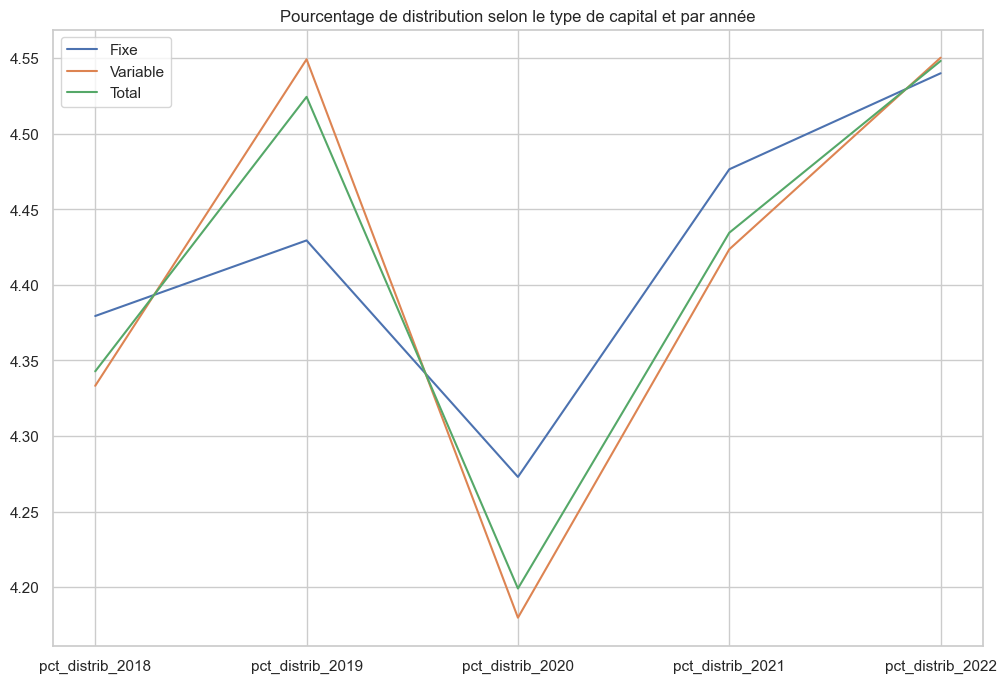

In [23]:
plot_from_dataframe(df_pct_distrib_selon_capital.drop("moyenne sur l'ensemble",axis=1),"Pourcentage de distribution selon le type de capital et par année")

On peut voir que le taux de distribution des SCPI résidentielles est basse mais on verra par la suite que celui-ci est rattrapé par une variation du prix d'aquisition plus élevé.

### Graphiques concernant la variation des prix d'acquisition d'une année sur l'autre (en %)

On va alors calculer la moyenne des variation des prix en fonction de chaque année et par catégorie :

In [24]:
df_variation_prix_selon_categorie = dataframe_means_from_criteria(year,df,'variation_prix','categorie')
df_variation_prix_selon_categorie

,variation_prix_2018,variation_prix_2019,variation_prix_2020,variation_prix_2021,variation_prix_2022,moyenne sur l'ensemble
Résidentiel,1.586000,2.334000,4.180000,2.254000,4.234000,3.250500
Santé et éducation,0.567500,1.142500,4.642500,0.000000,0.575000,1.590000
Tourisme et loisirs,7.113333,0.953333,3.630000,1.233333,-1.886667,0.982500
Diversifiée,0.486154,0.928462,1.005385,0.223846,0.820000,0.744423
Bureau,0.830789,1.288947,1.544474,-0.404211,0.281842,0.677763
Activités / Logistique,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.250000
Commerce,0.210556,0.549444,-1.288333,-0.045556,-0.229444,-0.253472
Total,0.892927,1.098049,1.206463,0.020732,0.415244,0.726683


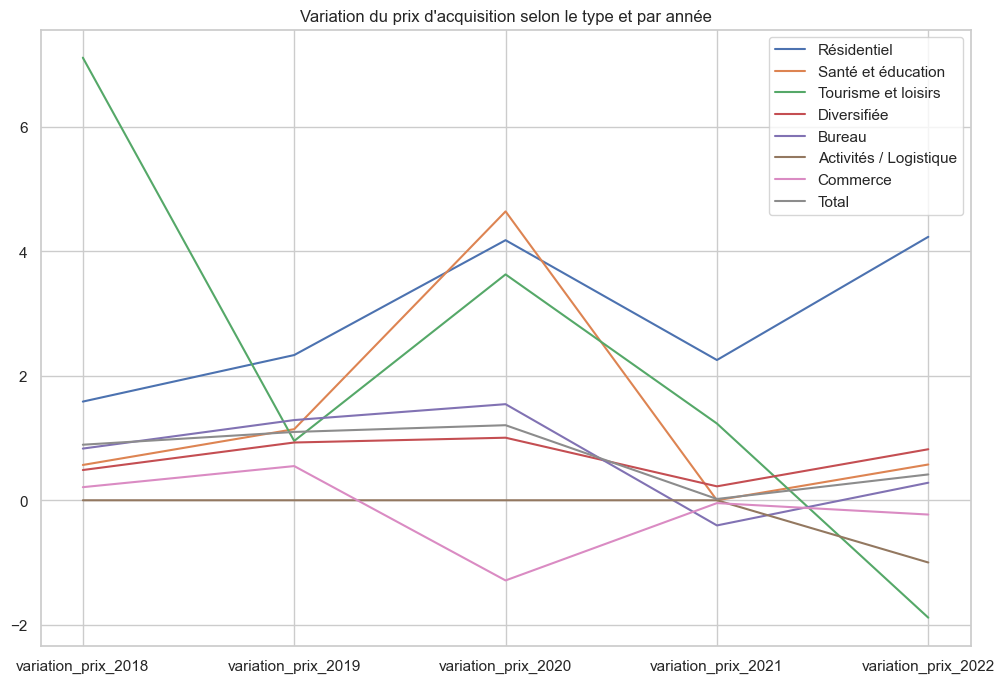

In [25]:
plot_from_dataframe(df_variation_prix_selon_categorie.drop("moyenne sur l'ensemble",axis=1),"Variation du prix d'acquisition selon le type et par année")

In [26]:
df_variation_prix_selon_type_SCPI = dataframe_means_from_criteria(year,df,'variation_prix','type_SCPI')
df_variation_prix_selon_type_SCPI

,variation_prix_2018,variation_prix_2019,variation_prix_2020,variation_prix_2021,variation_prix_2022,moyenne sur l'ensemble
SCPI de plus value,2.570000,2.355000,6.305000,3.745000,2.580000,3.746250
SCPI de rendement,0.851000,1.066625,1.079000,-0.072375,0.361125,0.608594
Total,0.892927,1.098049,1.206463,0.020732,0.415244,0.726683


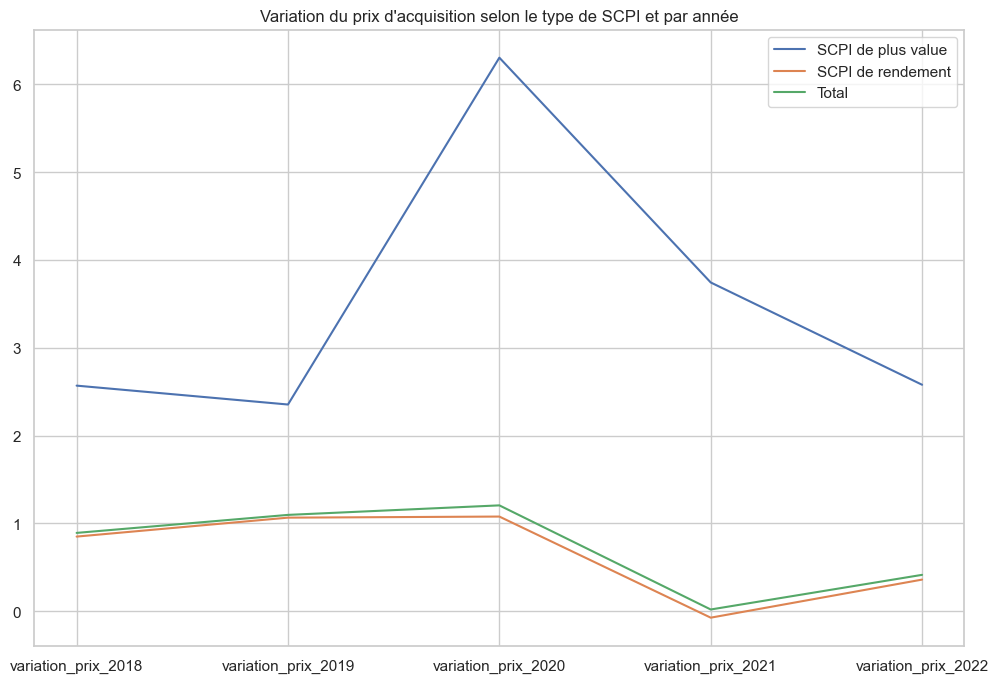

In [27]:
plot_from_dataframe(df_variation_prix_selon_type_SCPI.drop("moyenne sur l'ensemble",axis=1),"Variation du prix d'acquisition selon le type de SCPI et par année")

In [28]:
df_variation_prix_selon_capital = dataframe_means_from_criteria(year,df,'variation_prix','capital')
df_variation_prix_selon_capital

,variation_prix_2018,variation_prix_2019,variation_prix_2020,variation_prix_2021,variation_prix_2022,moyenne sur l'ensemble
Variable,1.163077,1.151231,1.315385,0.346923,0.711846,0.881346
Fixe,-0.140000,0.894706,0.790000,-1.226471,-0.718824,-0.065147
Total,0.892927,1.098049,1.206463,0.020732,0.415244,0.726683


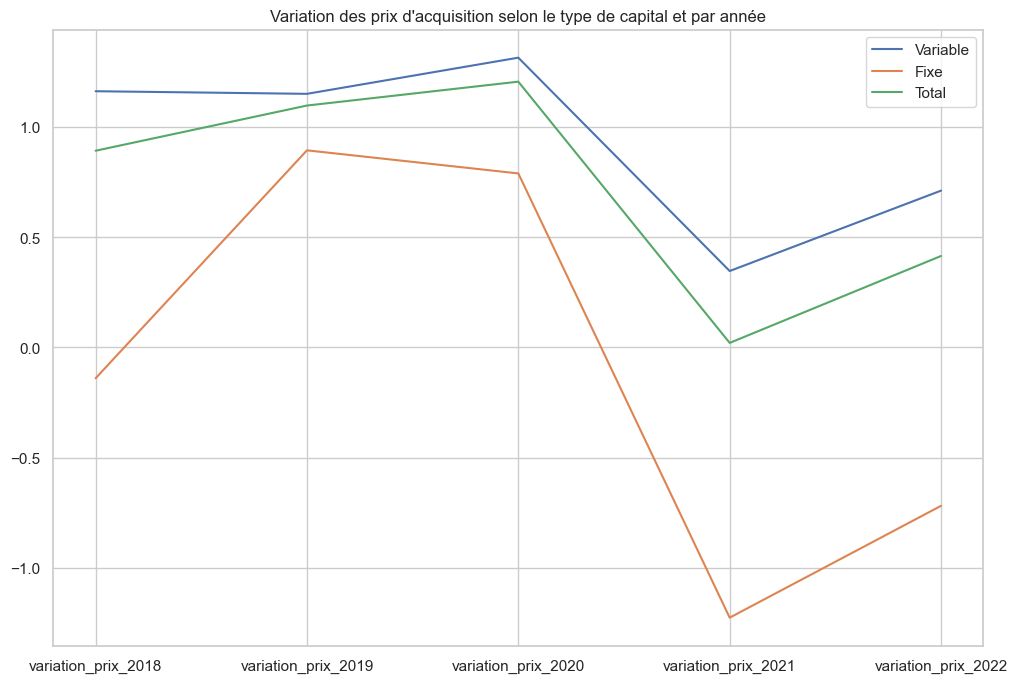

In [29]:
plot_from_dataframe(df_variation_prix_selon_capital.drop("moyenne sur l'ensemble",axis=1),"Variation des prix d'acquisition selon le type de capital et par année")

### Analyse de la volatilité

Représention de la volatilité (moyenne quadratique des variations de rendement), ici qui met en lumière les variations de rendement excessives :

In [30]:
df[['volatilite_pct_distrib','categorie']].dropna().groupby(['categorie']).mean().sort_values(by='volatilite_pct_distrib',ascending=True)

,volatilite_pct_distrib
categorie,
Bureau,0.317082
Santé et éducation,0.370557
Résidentiel,0.473710
Activités / Logistique,0.484407
Commerce,0.549256
Diversifiée,0.655065
Tourisme et loisirs,1.942504


Même chose pour les prix d'acquisition :

In [31]:
df[['volatilite_variation_prix','categorie']].dropna().groupby(['categorie']).mean().sort_values(by='volatilite_variation_prix',ascending=True)

,volatilite_variation_prix
categorie,
Activités / Logistique,0.500000
Diversifiée,1.007685
Bureau,2.227858
Commerce,2.786324
Santé et éducation,2.860771
Tourisme et loisirs,2.900578
Résidentiel,3.963217


Même chose pour les SCPI de type capitaux fixe ou variable :

In [32]:
df[['volatilite_pct_distrib','volatilite_variation_prix','capital']].dropna().groupby(['capital']).mean().sort_values(by='volatilite_pct_distrib',ascending=True)

,volatilite_pct_distrib,volatilite_variation_prix
capital,,
Variable,0.469399,1.471849
Fixe,0.594313,5.453119


Voici les observations que l'on peut en tirer :

Les SPCI de santé et d'éducation, de tourisme/loisir et diversifiés sont les plus rentables. En revanche, les rendements sont très volatils pour le type "tourisme et de loisir" alors celles diversifiées restent sures car varient moins dans le temps.

On voit clairement l'effet du covid en 2020 qui a enfoncé le rendement des SCPI de commerce et augmenté le rendement des SCPI de santé et d'éducation.

L'écart type est très grand concernant les variations de prix et dépendent fortement de la conjoncture qui va être moins favorable en 2023. On va alors par la suite plutot chercher à prédire le pourcentage de distribution.

Les SCPI à rendement sont meilleures que celles à plus-value.

### Dummies, corrélation entre variables et sélection avant machine learning

In [33]:
df_c = transform_to_correlation_analysis(df)

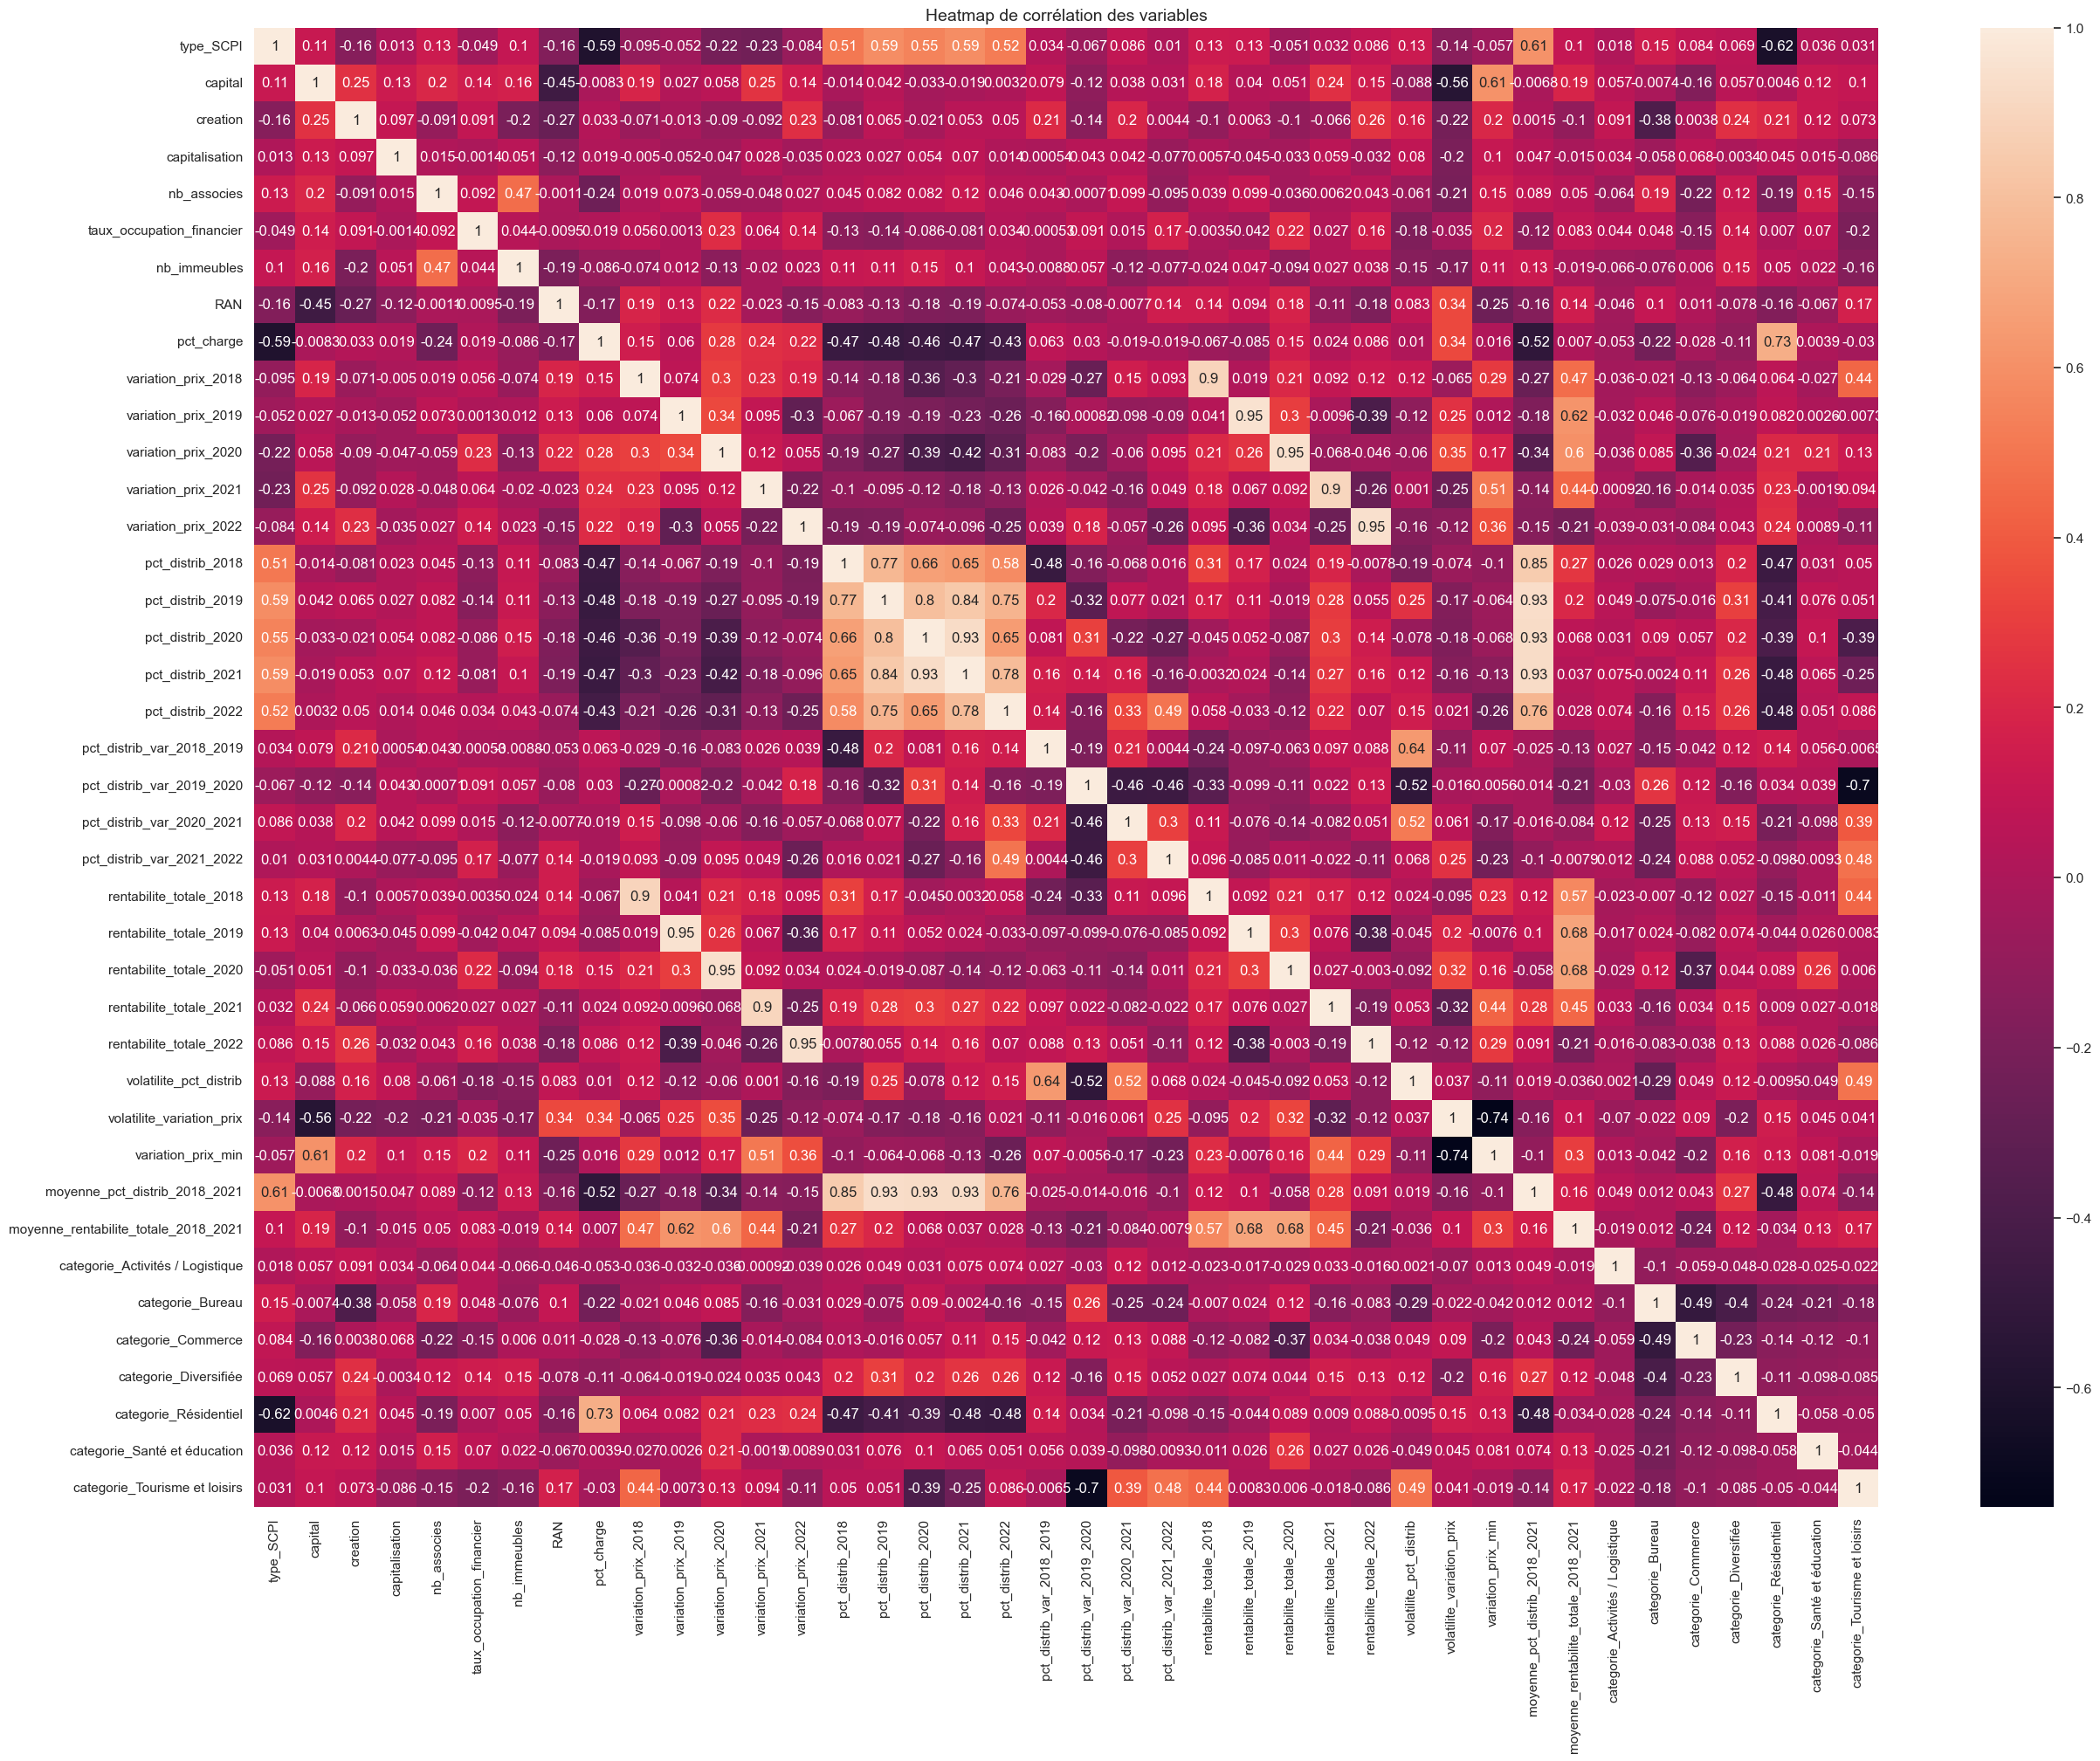

pct_distrib_2022                        1.000000
pct_distrib_2021                        0.782649
moyenne_pct_distrib_2018_2021           0.756008
pct_distrib_2019                        0.751832
pct_distrib_2020                        0.649665
pct_distrib_2018                        0.579339
type_SCPI                               0.524017
pct_distrib_var_2021_2022               0.492024
categorie_Résidentiel                   0.482996
pct_charge                              0.428299
pct_distrib_var_2020_2021               0.331830
variation_prix_2020                     0.311164
categorie_Diversifiée                   0.263985
variation_prix_min                      0.259347
variation_prix_2019                     0.259137
variation_prix_2022                     0.250994
rentabilite_totale_2021                 0.222136
variation_prix_2018                     0.209430
pct_distrib_var_2019_2020               0.164593
categorie_Bureau                        0.156334
categorie_Commerce  

In [34]:
correlation_importance_target(df_c,'pct_distrib_'+str(year)) 

On peut en déduire que les variables de pourcentages de distribution sont évidemment très corrélés entre eux, car le rendement des SCPI est essentiellement assurés par des loyers qui varient peu dans le temps.
On voit également que le pourcentage de distribution est corrélé à :
- scpi de rendement
- un pourcentage de charge peu important
- une catégorie comme l'on a vu plus haut qui peut jouer en faveur ou en défaveur

In [35]:
#Sauvegarde :
df_ml = transform_to_ML(df_c)

Après drop :
mean_squared_error entre la rentabilité de 2022 et la moyenne des années précédentes : 4.42277484375
mean_squared_error entre la pct de distribution de 2022 et la moyenne des années précédentes : 0.39717921874999995


In [36]:
df_c

,type_SCPI,capital,creation,capitalisation,nb_associes,taux_occupation_financier,nb_immeubles,RAN,pct_charge,variation_prix_2018,...,variation_prix_min,moyenne_pct_distrib_2018_2021,moyenne_rentabilite_totale_2018_2021,categorie_Activités / Logistique,categorie_Bureau,categorie_Commerce,categorie_Diversifiée,categorie_Résidentiel,categorie_Santé et éducation,categorie_Tourisme et loisirs
1,1,1,2016,322.96,40109,99.52,70,28.157442,34.75995,0.00,...,0.00,4.1425,4.3925,False,False,False,True,False,False,False
3,1,1,1999,237.59,2428,86.90,136,10.330000,44.20000,1.38,...,0.00,4.1650,4.7425,False,False,True,False,False,False,False
4,1,1,2000,886.70,21179,90.06,74,20.460000,35.63000,0.00,...,0.00,3.7250,4.8750,False,True,False,False,False,False,False
6,1,0,1982,42.30,3346,94.98,95,34.630000,50.83000,-4.82,...,-13.10,5.6700,-0.5500,False,False,True,False,False,False,False
7,1,1,1986,75.30,6927,90.21,176,7.890000,31.77000,0.00,...,0.00,4.2775,4.2775,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,1,1,2018,2790.77,5218,79.20,430,1.030000,68.39000,0.00,...,1.03,5.5950,7.0675,False,False,False,False,True,False,False
103,1,0,2011,62.70,44428,98.39,148,131.440000,41.70000,2.77,...,-0.45,3.1000,4.9925,False,False,True,False,False,False,False
104,1,0,1968,322.10,5692,96.20,209,33.080000,15.02000,1.30,...,0.00,5.5075,6.7650,False,True,False,False,False,False,False
105,1,1,2003,5156.73,42,90.31,42,24.380000,34.75995,0.00,...,0.00,3.8825,4.2150,False,True,False,False,False,False,False


La moyenne de la somme des carrées des erreurs (comparaison entre les années précédentes et l'année 2024) étant de 0.39, on va essayer de mieux faire avec le machine learning.

In [37]:
#Sauvegarde :
df_ml.to_excel(path_data_processed + 'df_ml.xlsx')

# Machine learning

### Sélection du meilleur modèle

In [38]:
df_ml = pd.read_excel(path_data_processed + 'df_ml.xlsx',index_col=0)
df_ml.head()

,type_SCPI,capital,nb_immeubles,pct_charge,variation_prix_2018,variation_prix_2019,variation_prix_2020,variation_prix_2021,variation_prix_2022,pct_distrib_2018,...,pct_distrib_2021,pct_distrib_2022,variation_prix_min,categorie_Activités / Logistique,categorie_Bureau,categorie_Commerce,categorie_Diversifiée,categorie_Résidentiel,categorie_Santé et éducation,categorie_Tourisme et loisirs
1,1,1,70,34.75995,0.00,1.00,0.00,0.00,0.0,0.00,...,5.84,5.97,0.0,False,False,False,True,False,False,False
3,1,1,136,44.20000,1.38,0.93,0.00,0.00,0.0,3.95,...,4.80,4.51,0.0,False,False,True,False,False,False,False
4,1,1,74,35.63000,0.00,0.98,3.17,0.45,0.0,3.85,...,3.53,4.00,0.0,False,True,False,False,False,False,False
7,1,1,176,31.77000,0.00,0.00,0.00,0.00,0.0,4.34,...,4.08,4.31,0.0,False,False,False,True,False,False,False
8,1,1,20,5.14000,0.00,0.00,0.00,0.00,0.0,4.60,...,2.64,5.05,0.0,False,False,False,False,False,False,True


In [39]:
class regressions_compare_express:

    list_model = [
        LinearRegression(),
        Ridge(),
        ElasticNet(alpha=1.0, l1_ratio=0.5),
        Lasso(),
        RandomForestRegressor(n_estimators = 1, random_state = 0),
        RandomForestRegressor(n_estimators = 4, random_state = 0),    
        RandomForestRegressor(n_estimators = 10, random_state = 0),#avec aussi plein de variables
        GradientBoostingRegressor(),
        XGBRegressor(),
        ExtraTreesRegressor(),
        KNeighborsRegressor(n_neighbors=3),
        KNeighborsRegressor(n_neighbors=10),
        LGBMRegressor()
    ]     

    def __init__(self, X, y, score_metric):
        self.X = X
        self.y = y
        self.score_metric = score_metric
        
    def poly(self) -> pd.DataFrame:
        #'r2','neg_mean_squared_error','neg_mean_absolute_error'

        cross_val_score_number_split = 4
        list_number_degree = [2,3]

        list_model_name=[] 
        list_scores=[]
        list_time=[]

        for number_degree in list_number_degree:
            poly = PolynomialFeatures(degree=number_degree, include_bias=False)
            X_poly = poly.fit_transform(self.X)
            model = LinearRegression()
            list_model_name.append("régression polynomiale d'ordre "+str(number_degree))

            start_time = time.time()
            #scores = cross_val_score(model, X, y, cv=cross_val_score_number_split)
            cv = cross_validate(model, X_poly, self.y, scoring=[self.score_metric], cv=cross_val_score_number_split, n_jobs=5, verbose=0)
            score = cv['test_'+self.score_metric].mean()

            delta_time = format(time.time() - start_time)
            list_scores.append(score)
            list_time.append(delta_time)
            print("Score de",score,"pour la régression polynomiale d'ordre",str(number_degree))

        dataframe_rslt = pd.DataFrame({
        'Modèle': list_model_name,
        self.score_metric: list_scores,
        'Temps de calcul': list_time
        })
        dataframe_rslt.sort_values(by=[self.score_metric])

        return dataframe_rslt    

    def no_poly(self) -> pd.DataFrame:
        #'r2','neg_mean_squared_error','neg_mean_absolute_error'
        cross_val_score_number_split = 4

        list_model = [
        LinearRegression(),
        Ridge(),
        ElasticNet(alpha=1.0, l1_ratio=0.5),
        Lasso(),
        RandomForestRegressor(n_estimators = 1, random_state = 0),
        RandomForestRegressor(n_estimators = 4, random_state = 0),    
        RandomForestRegressor(n_estimators = 10, random_state = 0),#avec aussi plein de variables
        GradientBoostingRegressor(),
        XGBRegressor(),
        ExtraTreesRegressor(),
        KNeighborsRegressor(n_neighbors=3),
        KNeighborsRegressor(n_neighbors=10),
        LGBMRegressor()
        ]  

        list_scores=[]
        list_time=[]

        for model in list_model:
            start_time = time.time()
            cv = cross_validate(model, self.X, self.y, scoring=[self.score_metric], cv=cross_val_score_number_split, n_jobs=5, verbose=0)
            score = cv['test_'+self.score_metric].mean()
            delta_time = format(time.time() - start_time)
            list_scores.append(score)
            list_time.append(delta_time)
            print("Score de",score,"pour",model)

        dataframe_rslt = pd.DataFrame({
        'Modèle': list_model,
        self.score_metric: list_scores,
        'Temps de calcul': list_time
        })
        dataframe_rslt.sort_values(by=[self.score_metric],ascending=False)

        return dataframe_rslt

    def poly_and_no_poly(self) -> pd.DataFrame:
        dataframe_rslt1 = self.poly()
        dataframe_rslt2 = self.no_poly()
        dataframe_rslt = pd.concat([dataframe_rslt1, dataframe_rslt2], ignore_index=True).sort_values(by=[self.score_metric],ascending=False)
        return dataframe_rslt



In [40]:
def get_X_X_to_predict_y_ML(dataframe:pd.DataFrame, col_target:str) -> (pd.Series, pd.Series, pd.Series):
    X = StandardScaler().fit_transform(dataframe.drop([col_target,'variation_prix_'+str(year)],axis=1))
    X_to_predict = StandardScaler().fit_transform(dataframe.drop(['pct_distrib_'+str(year-4),'variation_prix_'+str(year-4)],axis=1))
    y = dataframe[col_target]
    return X,X_to_predict,y

def save_model(X:pd.Series,y:pd.Series,model,file_name:str):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X, y)

    with open(file_name, 'wb') as f:
        pickle.dump(pipeline, f)
    print("Le modèle avec normalisation a été enregistré dans",file_name)    
    return pipeline

In [41]:
X,X_to_predict,y=get_X_X_to_predict_y_ML(df_ml,'pct_distrib_'+str(year)) 
dataframe_rslt = regressions_compare_express(X,y,'neg_mean_squared_error').poly_and_no_poly()
dataframe_rslt

Score de -9.221311716952872 pour la régression polynomiale d'ordre 2
Score de -6.275504561750999 pour la régression polynomiale d'ordre 3
Score de -0.17646331981736832 pour LinearRegression()
Score de -0.17421222609152925 pour Ridge()
Score de -0.8061539227873294 pour ElasticNet()
Score de -1.2745695608805443 pour Lasso()
Score de -0.39617749999999996 pour RandomForestRegressor(n_estimators=1, random_state=0)
Score de -0.3048221875 pour RandomForestRegressor(n_estimators=4, random_state=0)
Score de -0.28423465000000003 pour RandomForestRegressor(n_estimators=10, random_state=0)
Score de -0.26434505304807643 pour GradientBoostingRegressor()
Score de -0.40184619263293236 pour XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=No

,Modèle,neg_mean_squared_error,Temps de calcul
3,Ridge(),-0.174212,0.011967658996582031
2,LinearRegression(),-0.176463,0.012208938598632812
9,GradientBoostingRegressor(),-0.264345,0.06691956520080566
8,"RandomForestRegressor(n_estimators=10, random_...",-0.284235,0.02302861213684082
7,"RandomForestRegressor(n_estimators=4, random_s...",-0.304822,0.07830142974853516
11,ExtraTreesRegressor(),-0.312426,0.12176632881164551
6,"RandomForestRegressor(n_estimators=1, random_s...",-0.396177,0.07879042625427246
10,"XGBRegressor(base_score=None, booster=None, ca...",-0.401846,0.06839656829833984
12,KNeighborsRegressor(n_neighbors=3),-0.533920,0.06693458557128906
13,KNeighborsRegressor(n_neighbors=10),-0.681179,0.05498099327087402


### Prédiction de l'année suivante avec le meilleur modèle et sauvegarde

On suppose que la situation du marché va être similaire d'une année sur l'autre. On va alors faire une translation d'une année.

In [42]:
chosen_model = Ridge()
chosen_model.fit(X,y)

df_conclusion = df_ml
df_conclusion['prediction_'+str(year)]=chosen_model.predict(X)
df_conclusion['prediction_'+str(year+1)]=chosen_model.predict(X_to_predict)

In [43]:
df_conclusion

,type_SCPI,capital,nb_immeubles,pct_charge,variation_prix_2018,variation_prix_2019,variation_prix_2020,variation_prix_2021,variation_prix_2022,pct_distrib_2018,...,variation_prix_min,categorie_Activités / Logistique,categorie_Bureau,categorie_Commerce,categorie_Diversifiée,categorie_Résidentiel,categorie_Santé et éducation,categorie_Tourisme et loisirs,prediction_2022,prediction_2023
1,1,1,70,34.75995,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,False,False,False,True,False,False,False,5.996208,5.813923
3,1,1,136,44.20000,1.38,0.93,0.00,0.00,0.00,3.95,...,0.00,False,False,True,False,False,False,False,4.759174,4.382679
4,1,1,74,35.63000,0.00,0.98,3.17,0.45,0.00,3.85,...,0.00,False,True,False,False,False,False,False,3.741242,3.917502
7,1,1,176,31.77000,0.00,0.00,0.00,0.00,0.00,4.34,...,0.00,False,False,False,True,False,False,False,4.443239,4.565014
8,1,1,20,5.14000,0.00,0.00,0.00,0.00,0.00,4.60,...,0.00,False,False,False,False,False,False,True,4.808152,6.603072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,1,1,430,68.39000,0.00,2.06,2.80,1.03,1.89,3.53,...,1.03,False,False,False,False,True,False,False,5.230915,4.591771
103,1,0,148,41.70000,2.77,5.17,-0.45,0.08,11.89,2.90,...,-0.45,False,False,True,False,False,False,False,3.717209,4.582186
104,1,0,209,15.02000,1.30,3.50,0.23,0.00,0.27,5.48,...,0.00,False,True,False,False,False,False,False,5.256879,5.223400
105,1,1,42,34.75995,0.00,0.00,0.00,1.33,0.66,4.00,...,0.00,False,True,False,False,False,False,False,3.904339,3.994538


In [44]:
df=add_to_dataframe_means_variation_prix(df,year) 
df_conclusion = df_conclusion.merge(df[['scpi_liste','moyenne_pct_distrib_'+str(year-4)+'_'+str(year-1),'categorie','moyenne_variation_prix_'+str(year-4)+'_'+str(year)]], left_index=True, right_index=True, how='inner')
df_conclusion['rentabilite_totale_'+str(year+1)+'_predite']=df_conclusion.apply(lambda x:x['moyenne_variation_prix_'+str(year-4)+'_'+str(year)]+x['prediction_'+str(year+1)],axis=1)
df_conclusion[['moyenne_variation_prix_'+str(year-4)+'_'+str(year),'moyenne_pct_distrib_'+str(year-4)+'_'+str(year-1),'variation_prix_min','pct_distrib_'+str(year),'prediction_'+str(year),'prediction_'+str(year+1),'rentabilite_totale_'+str(year+1)+'_predite']]=round(df_conclusion[['moyenne_variation_prix_'+str(year-4)+'_'+str(year),'moyenne_pct_distrib_'+str(year-4)+'_'+str(year-1),'variation_prix_min','pct_distrib_'+str(year),'prediction_'+str(year),'prediction_'+str(year+1),'rentabilite_totale_'+str(year+1)+'_predite']],2)
df_conclusion = df_conclusion[['scpi_liste','moyenne_pct_distrib_'+str(year-4)+'_'+str(year-1),'variation_prix_min','pct_distrib_'+str(year),'prediction_'+str(year),'prediction_'+str(year+1),'rentabilite_totale_'+str(year+1)+'_predite']].sort_values(by=['rentabilite_totale_'+str(year+1)+'_predite'],ascending=False)


In [45]:
pipeline = save_model(X,y,LinearRegression(),'modele.pickle')

Le modèle avec normalisation a été enregistré dans modele.pickle


### Conclusion

Rappelons les critères que l'on s'est fixés :
- des SCPI suffisamment anciennes
- un pourcentage de distribution le plus élevé possible
- se focaliser davantage sur le pourcentage de distribution car compter sur la variation des prix n'est pas fiable avec le mauvais contexte immobilier en 2023
- avoir une volatilité modérée pour un risque modéré

On avait obtenu une moyenne du carrée des erreurs de 0.39 entre les années précedentes et la moyenne du pourcentage de distribution de 2023.
La moyenne du pourcentage de distribution en 2022 a été de 4.4%.

Le meilleur modèle de machine learning avec toutes les données est la régression de Ridge appliquée à l'ensemble des données.

Les SCPI gagnantes sont :

In [46]:
df_conclusion.sort_values(by=['rentabilite_totale_'+str(year+1)+'_predite'],ascending=False).head(20)

,scpi_liste,moyenne_pct_distrib_2018_2021,variation_prix_min,pct_distrib_2022,prediction_2022,prediction_2023,rentabilite_totale_2023_predite
101,kyaneos-pierre,5.60,1.03,5.37,5.23,4.59,7.84
8,atream-hotels,3.59,0.00,5.05,4.81,6.60,7.59
91,logipierre-3,3.64,0.00,5.31,5.05,6.59,7.57
61,aestiam-caphebergimmo,3.55,-5.66,5.00,5.45,6.46,7.44
85,corum-origin,6.66,0.00,6.88,6.83,6.62,7.36
88,coeur-de-regions,6.31,0.31,6.40,6.39,6.34,7.08
55,pierval-sante,5.10,0.00,5.35,5.25,5.19,6.78
35,cap-foncieres-territoires,5.42,0.00,5.85,5.72,5.91,6.66
1,corum-xl,4.14,0.00,5.97,6.00,5.81,6.56
84,corum-xl,5.71,0.00,5.97,5.91,5.81,6.56
